In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
!pip install hurst
from hurst import compute_Hc

In [21]:
prices = pd.read_csv('finaldata.csv', parse_dates=['Timestamp'], index_col='Timestamp')

prices = prices.apply(lambda col: col.abs() if col.name != 'Timestamp' else col)


In [22]:
prices

,Instr1,Instr2,Instr3,Instr4,Instr5,Instr6,Instr7,Instr8,Instr9,Instr10,Instr11,Instr12,Instr13,Instr14,Instr15,Instr16,Instr17,Instr18,Instr19,Instr20
Timestamp,,,,,,,,,,,,,,,,,,,,
2016-03-11,1.416659,1.420558,1.426727,1.426903,1.424853,1.421595,1.414042,1.403588,1.393133,1.382952,1.372094,1.360408,1.351622,1.343384,1.333519,1.325976,1.319087,1.313109,1.309208,1.306107
2016-03-14,1.462301,1.472009,1.482483,1.486425,1.485694,1.483600,1.477712,1.468183,1.459244,1.449825,1.439647,1.429297,1.421079,1.414141,1.405593,1.398603,1.393041,1.387593,1.384227,1.381651
2016-03-15,1.504228,1.514607,1.527892,1.535233,1.535472,1.533584,1.527089,1.517461,1.508316,1.499284,1.488712,1.477881,1.469107,1.461563,1.452365,1.444678,1.438367,1.432122,1.427919,1.425299
2016-03-16,1.419844,1.426643,1.440522,1.448331,1.447591,1.444372,1.437431,1.428227,1.419032,1.410119,1.399115,1.387963,1.378961,1.370482,1.361888,1.354871,1.348509,1.342255,1.338886,1.336325
2016-03-17,1.355626,1.360255,1.373846,1.382261,1.383064,1.381734,1.377009,1.370292,1.363145,1.355088,1.345784,1.335752,1.327977,1.320802,1.312817,1.306453,1.301592,1.296917,1.294369,1.292677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-30,0.835726,0.779651,0.811547,0.839093,0.864957,0.887792,0.908630,0.926472,0.941884,0.955530,0.966677,0.975294,0.981823,0.989337,0.998928,1.007441,1.015631,1.022611,1.028738,1.034918
2023-12-01,0.626091,0.664025,0.698311,0.730168,0.758640,0.782129,0.802080,0.818593,0.833516,0.846164,0.856458,0.865071,0.871727,0.881696,0.890817,0.898892,0.907484,0.914124,0.920744,0.929995
2023-12-04,0.580980,0.625299,0.666123,0.703383,0.737745,0.766944,0.791685,0.813265,0.831472,0.846861,0.859302,0.869422,0.879116,0.890729,0.900785,0.910606,0.919412,0.927077,0.934759,0.945104


In [23]:
prices_train=prices['2016-03-12':'2020-01-24']
prices_test=prices['2020-03-13':'2023-12-5']

In [24]:
cumret_train = np.log(prices_train).diff().cumsum()+1
cumret_train.dropna(how='all', inplace=True)
cumret_train.dropna(axis=1, inplace=True)
cumret_test = np.log(prices_test).diff().cumsum()+1
cumret_test.dropna(how='all', inplace=True)

In [25]:
cumret_train = cumret_train / cumret_train.iloc[0]
cumret_test = cumret_test / cumret_test.iloc[0]

In [26]:
def parse_pair(pair):
    '''
    parse pair string S1-S2
    return tickers S1, S2
    '''
    dp = pair.find('-')
    s1 = pair[:dp]
    s2 = pair[dp+1:]

    return s1,s2

def cadf_pvalue(s1, s2, cumret):
    '''
    perform CADF cointegration tests
    since it is sensitive to the order of stocks in the pair, perform both tests (s1-2 and s2-s1)
    return the smallest p-value of two tests
    '''
    from statsmodels.tsa.stattools import coint

    p1 = coint(cumret[s1], cumret[s2])[1]
    p2 = coint(cumret[s2], cumret[s1])[1]

    return min(p1,p2)

def calculate_halflife(spread):
    '''
    calculate half-life of mean reversion of the spread
    '''
    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant

    ylag = spread.shift()
    deltay = spread - ylag
    ylag.dropna(inplace=True)
    deltay.dropna(inplace=True)

    res = OLS(deltay, add_constant(ylag)).fit()
    halflife = -np.log(2)/res.params[0]

    return halflife

def calculate_metrics(pairs, cumret, pairs_df):
    '''
    calculate metrics for pairs using data in cumret
    return dataframe of results
    '''
    from hurst import compute_Hc
    from statsmodels.tsa.stattools import adfuller
    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant
    from statsmodels.tsa.stattools import coint

    cols = ['Distance', 'CADF p-value', 'ADF p-value', 'Spread SD', 'Pearson r',
        'Num zero-crossings', 'Hurst Exponent', 'Half-life of mean reversion', '% days within historical 2-SD band']
    results = pd.DataFrame(index=pairs, columns=cols)

    for pair in pairs:
        s1,s2 = parse_pair(pair)
        hedge_ratio = pairs_df.loc[pair]['Hedge ratio']
        spread = cumret[s1] - hedge_ratio*cumret[s2]
        results.loc[pair]['CADF p-value'] = coint(cumret[s1], cumret[s2])[1]
        results.loc[pair]['ADF p-value'] = adfuller(spread)[1]
        hist_mu = pairs_df.loc[pair]['Spread mean'] # historical mean
        hist_sd = pairs_df.loc[pair]['Spread SD'] # historical standard deviation
        results.loc[pair]['Spread SD'] = hist_sd
        results.loc[pair]['Pearson r'] = np.corrcoef(cumret[s1], cumret[s2])[0][1]
        # subtract the mean to calculate distances and num_crossings
        spread_nm = spread - hist_mu
        results.loc[pair]['Distance'] = np.sqrt(np.sum((spread_nm)**2))
        results.loc[pair]['Num zero-crossings'] = ((spread_nm[1:].values * spread_nm[:-1].values) < 0).sum()
        results.loc[pair]['Hurst Exponent'] = compute_Hc(spread)[0]
        results.loc[pair]['Half-life of mean reversion'] = calculate_halflife(spread)
        results.loc[pair]['% days within historical 2-SD band'] = (abs(spread-hist_mu) < 2*hist_sd).sum() / len(spread) * 100

    return results

def plot_pairs(pairs, cumret_train, cumret_test):
    '''
    plot cumulative returns of the spread for each pair in pairs
    '''

    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant

    for pair in pairs:
        s1,s2 = parse_pair(pair)
        res = OLS(cumret_train[s1], add_constant(cumret_train[s2])).fit()
        spread_train = cumret_train[s1] - res.params[s2]*cumret_train[s2]
        spread_test = cumret_test[s1] - res.params[s2]*cumret_test[s2]
        spread_mean = spread_train.mean() # historical mean
        spread_std = spread_train.std() # historical standard deviation

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,4))
        fig.suptitle(f'Spread of {pair} pair', fontsize=16)
        ax1.plot(spread_train, label='spread')
        ax1.set_title('Formation period')
        ax1.axhline(y=spread_mean, color='g', linestyle='dotted', label='mean')
        ax1.axhline(y=spread_mean+2*spread_std, color='r', linestyle='dotted', label='2-SD band')
        ax1.axhline(y=spread_mean-2*spread_std, color='r', linestyle='dotted')
        ax1.legend()
        ax2.plot(spread_test, label='spread')
        ax2.set_title('Trading period')
        ax2.axhline(y=spread_mean, color='g', linestyle='dotted', label='mean')
        ax2.axhline(y=spread_mean+2*spread_std, color='r', linestyle='dotted', label='2-SD band')
        ax2.axhline(y=spread_mean-2*spread_std, color='r', linestyle='dotted')
        ax2.legend()

def select_pairs(train):
    '''
    select pairs using data from train dataframe
    return dataframe of selected pairs
    '''
    tested = []

    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant
    from hurst import compute_Hc
    from statsmodels.tsa.stattools import adfuller
    from statsmodels.tsa.stattools import coint

    cols = ['Distance', 'Num zero-crossings', 'Pearson r', 'Spread mean',
            'Spread SD', 'Hurst Exponent', 'Half-life of mean reversion', 'Hedge ratio']
    pairs = pd.DataFrame(columns=cols)

    for s1 in train.columns:
        for s2 in train.columns:
            if s1!=s2 and (f'{s1}-{s2}' not in tested):
                tested.append(f'{s1}-{s2}')
                cadf_p = coint(train[s1], train[s2])[1]
                if cadf_p<0.01 and (f'{s2}-{s1}' not in pairs.index): # stop if pair already added as s2-s1
                    res = OLS(train[s1], add_constant(train[s2])).fit()
                    hedge_ratio = res.params[s2]
                    if hedge_ratio > 0: # hedge ratio should be posititve
                        spread = train[s1] - hedge_ratio*train[s2]
                        hurst = compute_Hc(spread)[0]
                        if hurst<0.5:
                            halflife = calculate_halflife(spread)
                            if halflife>1 and halflife<30:
                                # subtract the mean to calculate distances and num_crossings
                                spread_nm = spread - spread.mean()
                                num_crossings = (spread_nm.values[1:] * spread_nm.values[:-1] < 0).sum()
                                if num_crossings>len(train.index)/252*12:
                                    distance = np.sqrt(np.sum(spread_nm**2))
                                    pearson_r = np.corrcoef(train[s1], train[s2])[0][1]
                                    pairs.loc[f'{s1}-{s2}'] = [distance, num_crossings, pearson_r, spread.mean(),
                                                               spread.std(), hurst, halflife, hedge_ratio]

    return pairs

In [27]:
# prepare data
train_form = cumret_train.loc['2016-03-15':'2018-12-31'] # formation period (train data)
train_trade = cumret_train.loc['2018-01-01':] # trading period (train data)
test_form = cumret_test.loc['2020-03-14':'2022-06-30'] # formation period (test data)
test_trade = cumret_test.loc['2020-07-01':] # trading period (test data)


In [28]:
train_form


,Instr1,Instr2,Instr3,Instr4,Instr5,Instr6,Instr7,Instr8,Instr9,Instr10,Instr11,Instr12,Instr13,Instr14,Instr15,Instr16,Instr17,Instr18,Instr19,Instr20
Timestamp,,,,,,,,,,,,,,,,,,,,
2016-03-15,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2016-03-16,0.943854,0.941828,0.942841,0.943553,0.942944,0.941989,0.941419,0.941332,0.940935,0.940677,0.939941,0.939258,0.938713,0.937711,0.937718,0.937835,0.937493,0.937178,0.937560,0.937486
2016-03-17,0.898843,0.895497,0.896837,0.898324,0.898799,0.899076,0.899842,0.901246,0.902040,0.902161,0.902338,0.902156,0.902251,0.901966,0.902184,0.902587,0.903180,0.903869,0.904765,0.905280
2016-03-18,0.911702,0.908070,0.908945,0.911170,0.912891,0.914029,0.915250,0.917110,0.917881,0.917947,0.917555,0.917271,0.916683,0.915662,0.915662,0.915242,0.914948,0.914701,0.915209,0.915304
2016-03-21,0.898843,0.893518,0.894397,0.895818,0.896214,0.895968,0.896639,0.897947,0.898646,0.898673,0.898239,0.896888,0.895767,0.893655,0.893093,0.892109,0.891866,0.891077,0.891706,0.891326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,0.480492,0.477611,0.472744,0.466669,0.463513,0.461673,0.465617,0.474927,0.479834,0.482948,0.485837,0.485076,0.482865,0.478241,0.473912,0.469642,0.462611,0.456658,0.450695,0.442898
2018-12-26,0.212608,0.198665,0.185095,0.169419,0.157544,0.146752,0.143553,0.147668,0.148291,0.143735,0.140920,0.133115,0.124006,0.109227,0.095360,0.081848,0.065896,0.051489,0.034546,0.015092
2018-12-27,0.376160,0.350535,0.340257,0.327523,0.317483,0.310473,0.308286,0.312180,0.313632,0.310416,0.308573,0.303309,0.297603,0.287045,0.277485,0.268092,0.257705,0.248688,0.237505,0.225481


In [29]:
pairs_train = select_pairs(train_form)
pairs_train


,Distance,Num zero-crossings,Pearson r,Spread mean,Spread SD,Hurst Exponent,Half-life of mean reversion,Hedge ratio
Instr1-Instr2,3.211422,52.0,0.990699,-0.007844,0.119517,0.383116,1.174012,1.004875
Instr1-Instr3,4.632493,43.0,0.980548,-0.014909,0.172404,0.342475,1.031763,1.023070
Instr1-Instr5,6.806915,44.0,0.957506,-0.025684,0.253327,0.354256,1.151599,1.004035
Instr2-Instr3,2.737957,61.0,0.993053,-0.006909,0.101896,0.385943,1.159932,1.021502
Instr4-Instr1,6.078341,55.0,0.963505,0.015377,0.226212,0.374966,1.008651,0.926985
...,...,...,...,...,...,...,...,...
Instr20-Instr2,17.256879,39.0,0.683497,0.058220,0.642235,0.330055,2.787786,0.694447
Instr20-Instr6,16.095621,45.0,0.732439,0.045360,0.599017,0.355111,2.323008,0.760387
Instr20-Instr7,16.206104,45.0,0.728067,0.043313,0.603129,0.367889,2.210081,0.730774
Instr20-Instr8,15.555384,57.0,0.753035,0.035916,0.578911,0.349470,2.268545,0.769488


In [30]:
pairs_train.index.rename('Pair', inplace=True)
pairs_train.to_csv('pairs13_16.csv')
pairs_train = pd.read_csv('pairs13_16.csv', index_col='Pair')
pairs_test = select_pairs(test_form)
pairs_test

,Distance,Num zero-crossings,Pearson r,Spread mean,Spread SD,Hurst Exponent,Half-life of mean reversion,Hedge ratio
Instr1-Instr3,5.530729,50.0,0.977670,-0.056023,0.227120,0.399636,1.605315,1.036509
Instr1-Instr4,7.295123,44.0,0.960816,-0.058916,0.299575,0.355565,1.306192,0.996477
Instr1-Instr5,9.318125,38.0,0.935226,-0.066153,0.382650,0.406361,1.545211,0.973519
Instr1-Instr6,10.410409,30.0,0.918442,-0.074135,0.427504,0.363332,1.319261,0.967977
Instr1-Instr7,10.410837,38.0,0.918435,-0.091874,0.427522,0.303365,1.371231,0.994676
Instr1-Instr10,11.935524,30.0,0.891255,-0.118540,0.490133,0.321148,1.493287,0.981415
Instr1-Instr11,12.031900,34.0,0.889382,-0.129567,0.494091,0.286460,1.624380,0.990507
Instr3-Instr5,6.114825,30.0,0.969188,-0.011581,0.251106,0.373588,1.220109,0.951602
Instr3-Instr6,7.461278,32.0,0.953763,-0.019687,0.306398,0.319558,1.004201,0.948141
Instr5-Instr2,8.428629,45.0,0.942797,0.050187,0.346122,0.388348,1.000188,0.923534


In [31]:
pairs_test.index.rename('Pair', inplace=True)
pairs_test.to_csv('pairs16_19.csv')
pairs_test = pd.read_csv('pairs16_19.csv', index_col='Pair')

In [32]:
# calculate metrics for selected pairs
metrics_train_form = calculate_metrics(pairs_train.index, train_form, pairs_train) # in formation period
metrics_train_trade = calculate_metrics(pairs_train.index, train_trade, pairs_train) # in trading period


In [33]:
# add hedge ratio to metrics just in case
metrics_train_form['Hedge ratio'] = pairs_train['Hedge ratio']
metrics_train_form

,Distance,CADF p-value,ADF p-value,Spread SD,Pearson r,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within historical 2-SD band,Hedge ratio
Pair,,,,,,,,,,
Instr1-Instr2,3.211422,0.0,0.0,0.119517,0.990699,52,0.383116,1.174012,98.063624,1.004875
Instr1-Instr3,4.632493,0.000007,0.000001,0.172404,0.980548,43,0.342475,1.031763,97.510373,1.023070
Instr1-Instr5,6.806915,0.001538,0.000256,0.253327,0.957506,44,0.354256,1.151599,96.957123,1.004035
Instr2-Instr3,2.737957,0.0,0.0,0.101896,0.993053,61,0.385943,1.159932,98.201936,1.021502
Instr4-Instr1,6.078341,0.002974,0.000531,0.226212,0.963505,55,0.374966,1.008651,97.372061,0.926985
...,...,...,...,...,...,...,...,...,...,...
Instr20-Instr2,17.256879,0.000015,0.000002,0.642235,0.683497,39,0.330055,2.787786,94.467497,0.694447
Instr20-Instr6,16.095621,0.000029,0.000004,0.599017,0.732439,45,0.355111,2.323008,95.159059,0.760387
Instr20-Instr7,16.206104,0.000403,0.00006,0.603129,0.728067,45,0.367889,2.210081,95.020747,0.730774


In [34]:
metrics_train_trade


,Distance,CADF p-value,ADF p-value,Spread SD,Pearson r,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within historical 2-SD band
Pair,,,,,,,,,
Instr1-Instr2,10.387452,0.0,0.0,0.119517,0.909547,42,0.418263,1.217876,86.491557
Instr1-Instr3,12.577316,0.0,0.005552,0.172404,0.870924,42,0.333536,1.124497,84.427767
Instr1-Instr5,14.590937,0.001787,0.000573,0.253327,0.821559,44,0.344312,1.363567,84.052533
Instr2-Instr3,7.552972,0.0,0.0,0.101896,0.953462,42,0.351505,0.999766,90.056285
Instr4-Instr1,13.884707,0.015221,0.000408,0.226212,0.831795,46,0.331874,1.15329,85.365854
...,...,...,...,...,...,...,...,...,...
Instr20-Instr2,23.514222,0.000851,0.000025,0.642235,0.482288,34,0.31628,1.851533,88.36773
Instr20-Instr6,21.000498,0.000634,0.0003,0.599017,0.616825,34,0.307251,1.37332,89.868668
Instr20-Instr7,20.37538,0.000907,0.000121,0.603129,0.646027,36,0.337435,1.435106,90.619137


In [35]:
# repeat the procedure for test data
metrics_test_form = calculate_metrics(pairs_test.index, test_form, pairs_test)
metrics_test_trade = calculate_metrics(pairs_test.index, test_trade, pairs_test)
metrics_test_form['Hedge ratio'] = pairs_test['Hedge ratio']

In [36]:
data_train = metrics_train_form.copy()
data_train['Num zero-crossings trade'] = metrics_train_trade['Num zero-crossings']
data_train

,Distance,CADF p-value,ADF p-value,Spread SD,Pearson r,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within historical 2-SD band,Hedge ratio,Num zero-crossings trade
Pair,,,,,,,,,,,
Instr1-Instr2,3.211422,0.0,0.0,0.119517,0.990699,52,0.383116,1.174012,98.063624,1.004875,42
Instr1-Instr3,4.632493,0.000007,0.000001,0.172404,0.980548,43,0.342475,1.031763,97.510373,1.023070,42
Instr1-Instr5,6.806915,0.001538,0.000256,0.253327,0.957506,44,0.354256,1.151599,96.957123,1.004035,44
Instr2-Instr3,2.737957,0.0,0.0,0.101896,0.993053,61,0.385943,1.159932,98.201936,1.021502,42
Instr4-Instr1,6.078341,0.002974,0.000531,0.226212,0.963505,55,0.374966,1.008651,97.372061,0.926985,46
...,...,...,...,...,...,...,...,...,...,...,...
Instr20-Instr2,17.256879,0.000015,0.000002,0.642235,0.683497,39,0.330055,2.787786,94.467497,0.694447,34
Instr20-Instr6,16.095621,0.000029,0.000004,0.599017,0.732439,45,0.355111,2.323008,95.159059,0.760387,34
Instr20-Instr7,16.206104,0.000403,0.00006,0.603129,0.728067,45,0.367889,2.210081,95.020747,0.730774,36


In [37]:
data_test = metrics_test_form.copy()
data_test['Num zero-crossings trade'] = metrics_test_trade['Num zero-crossings']
data_test

,Distance,CADF p-value,ADF p-value,Spread SD,Pearson r,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within historical 2-SD band,Hedge ratio,Num zero-crossings trade
Pair,,,,,,,,,,,
Instr1-Instr3,5.530729,0.0,0.0,0.22712,0.97767,50,0.399636,1.605315,97.138047,1.036509,64
Instr1-Instr4,7.295123,0.000008,0.000001,0.299575,0.960816,44,0.355565,1.306192,97.138047,0.996477,56
Instr1-Instr5,9.318125,0.000046,0.000006,0.38265,0.935226,38,0.406361,1.545211,96.464646,0.973519,48
Instr1-Instr6,10.410409,0.000938,0.000149,0.427504,0.918442,30,0.363332,1.319261,96.127946,0.967977,42
Instr1-Instr7,10.410837,0.006312,0.001234,0.427522,0.918435,38,0.303365,1.371231,95.791246,0.994676,46
Instr1-Instr10,11.935524,0.000719,0.000111,0.490133,0.891255,30,0.321148,1.493287,95.286195,0.981415,36
Instr1-Instr11,12.0319,0.001339,0.00022,0.494091,0.889382,34,0.28646,1.62438,94.949495,0.990507,38
Instr3-Instr5,6.114825,0.000021,0.000003,0.251106,0.969188,30,0.373588,1.220109,97.138047,0.951602,41
Instr3-Instr6,7.461278,0.000006,0.000001,0.306398,0.953763,32,0.319558,1.004201,96.464646,0.948141,40


In [38]:
data_train.dtypes


Distance                               object
CADF p-value                           object
ADF p-value                            object
Spread SD                              object
Pearson r                              object
Num zero-crossings                     object
Hurst Exponent                         object
Half-life of mean reversion            object
% days within historical 2-SD band     object
Hedge ratio                           float64
Num zero-crossings trade               object
dtype: object

In [39]:
# convert data to numeric types
data_train = data_train.apply(pd.to_numeric, errors='raise')
data_test = data_test.apply(pd.to_numeric, errors='raise')
data_test

,Distance,CADF p-value,ADF p-value,Spread SD,Pearson r,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within historical 2-SD band,Hedge ratio,Num zero-crossings trade
Pair,,,,,,,,,,,
Instr1-Instr3,5.530729,9.798357e-08,9.293451e-09,0.227120,0.977670,50,0.399636,1.605315,97.138047,1.036509,64
Instr1-Instr4,7.295123,7.871714e-06,8.866482e-07,0.299575,0.960816,44,0.355565,1.306192,97.138047,0.996477,56
Instr1-Instr5,9.318125,4.625643e-05,5.782944e-06,0.382650,0.935226,38,0.406361,1.545211,96.464646,0.973519,48
Instr1-Instr6,10.410409,9.381274e-04,1.489390e-04,0.427504,0.918442,30,0.363332,1.319261,96.127946,0.967977,42
Instr1-Instr7,10.410837,6.312237e-03,1.234114e-03,0.427522,0.918435,38,0.303365,1.371231,95.791246,0.994676,46
Instr1-Instr10,11.935524,7.185305e-04,1.114755e-04,0.490133,0.891255,30,0.321148,1.493287,95.286195,0.981415,36
Instr1-Instr11,12.031900,1.338695e-03,2.203084e-04,0.494091,0.889382,34,0.286460,1.624380,94.949495,0.990507,38
Instr3-Instr5,6.114825,2.142473e-05,2.553209e-06,0.251106,0.969188,30,0.373588,1.220109,97.138047,0.951602,41
Instr3-Instr6,7.461278,5.649057e-06,6.303469e-07,0.306398,0.953763,32,0.319558,1.004201,96.464646,0.948141,40


In [40]:
data_train.dtypes


Distance                              float64
CADF p-value                          float64
ADF p-value                           float64
Spread SD                             float64
Pearson r                             float64
Num zero-crossings                      int64
Hurst Exponent                        float64
Half-life of mean reversion           float64
% days within historical 2-SD band    float64
Hedge ratio                           float64
Num zero-crossings trade                int64
dtype: object

In [41]:
data_train.describe()


,Distance,CADF p-value,ADF p-value,Spread SD,Pearson r,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within historical 2-SD band,Hedge ratio,Num zero-crossings trade
count,108.000000,1.080000e+02,1.080000e+02,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,11.231718,4.987719e-04,8.854914e-05,0.418001,0.852469,42.703704,0.342082,1.638974,95.721275,0.831711,38.296296
std,3.803932,1.242959e-03,2.325721e-04,0.141568,0.086434,6.289376,0.025740,0.532680,0.979894,0.086438,8.601520
min,2.737957,1.054553e-24,1.137009e-25,0.101896,0.664257,35.000000,0.273107,1.008651,94.052559,0.665378,28.000000
25%,8.782259,2.237269e-07,2.179860e-08,0.326842,0.783176,38.000000,0.322958,1.181602,94.986169,0.764321,32.000000
50%,11.144758,6.399569e-06,7.184889e-07,0.414765,0.861485,42.000000,0.343063,1.448952,95.573997,0.824845,36.000000
75%,14.147360,1.571466e-04,2.130433e-05,0.526510,0.920874,45.000000,0.362677,2.076822,96.403873,0.897391,42.500000
max,19.077232,6.237919e-03,1.208581e-03,0.709981,0.993053,65.000000,0.391492,3.062359,98.201936,1.023070,60.000000


In [42]:
# remove pairs with too big or too small hedge ratio
data_train = data_train[(data_train['Hedge ratio']>0.2) & (data_train['Hedge ratio']<5)]
data_test = data_test[(data_test['Hedge ratio']>0.2) & (data_test['Hedge ratio']<5)]
data_train.corr()

,Distance,CADF p-value,ADF p-value,Spread SD,Pearson r,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within historical 2-SD band,Hedge ratio,Num zero-crossings trade
Distance,1.000000,0.089424,0.101265,1.000000,-0.982855,-0.130815,-0.066700,0.677560,-0.611608,-0.843795,-0.042853
CADF p-value,0.089424,1.000000,0.998724,0.089424,-0.124085,0.201444,-0.024690,0.019217,0.023656,-0.239789,0.472674
ADF p-value,0.101265,0.998724,1.000000,0.101265,-0.136606,0.194726,-0.013544,0.032337,0.016880,-0.247561,0.455195
Spread SD,1.000000,0.089424,0.101265,1.000000,-0.982855,-0.130815,-0.066700,0.677560,-0.611608,-0.843795,-0.042853
Pearson r,-0.982855,-0.124085,-0.136606,-0.982855,1.000000,0.078367,0.058302,-0.729912,0.632515,0.871696,0.031015
Num zero-crossings,-0.130815,0.201444,0.194726,-0.130815,0.078367,1.000000,0.356537,-0.218538,0.264504,-0.066081,0.546856
Hurst Exponent,-0.066700,-0.024690,-0.013544,-0.066700,0.058302,0.356537,1.000000,-0.144274,0.483151,0.202842,-0.033774
Half-life of mean reversion,0.677560,0.019217,0.032337,0.677560,-0.729912,-0.218538,-0.144274,1.000000,-0.754423,-0.648775,-0.275747
% days within historical 2-SD band,-0.611608,0.023656,0.016880,-0.611608,0.632515,0.264504,0.483151,-0.754423,1.000000,0.714797,0.152433
Hedge ratio,-0.843795,-0.239789,-0.247561,-0.843795,0.871696,-0.066081,0.202842,-0.648775,0.714797,1.000000,-0.165747


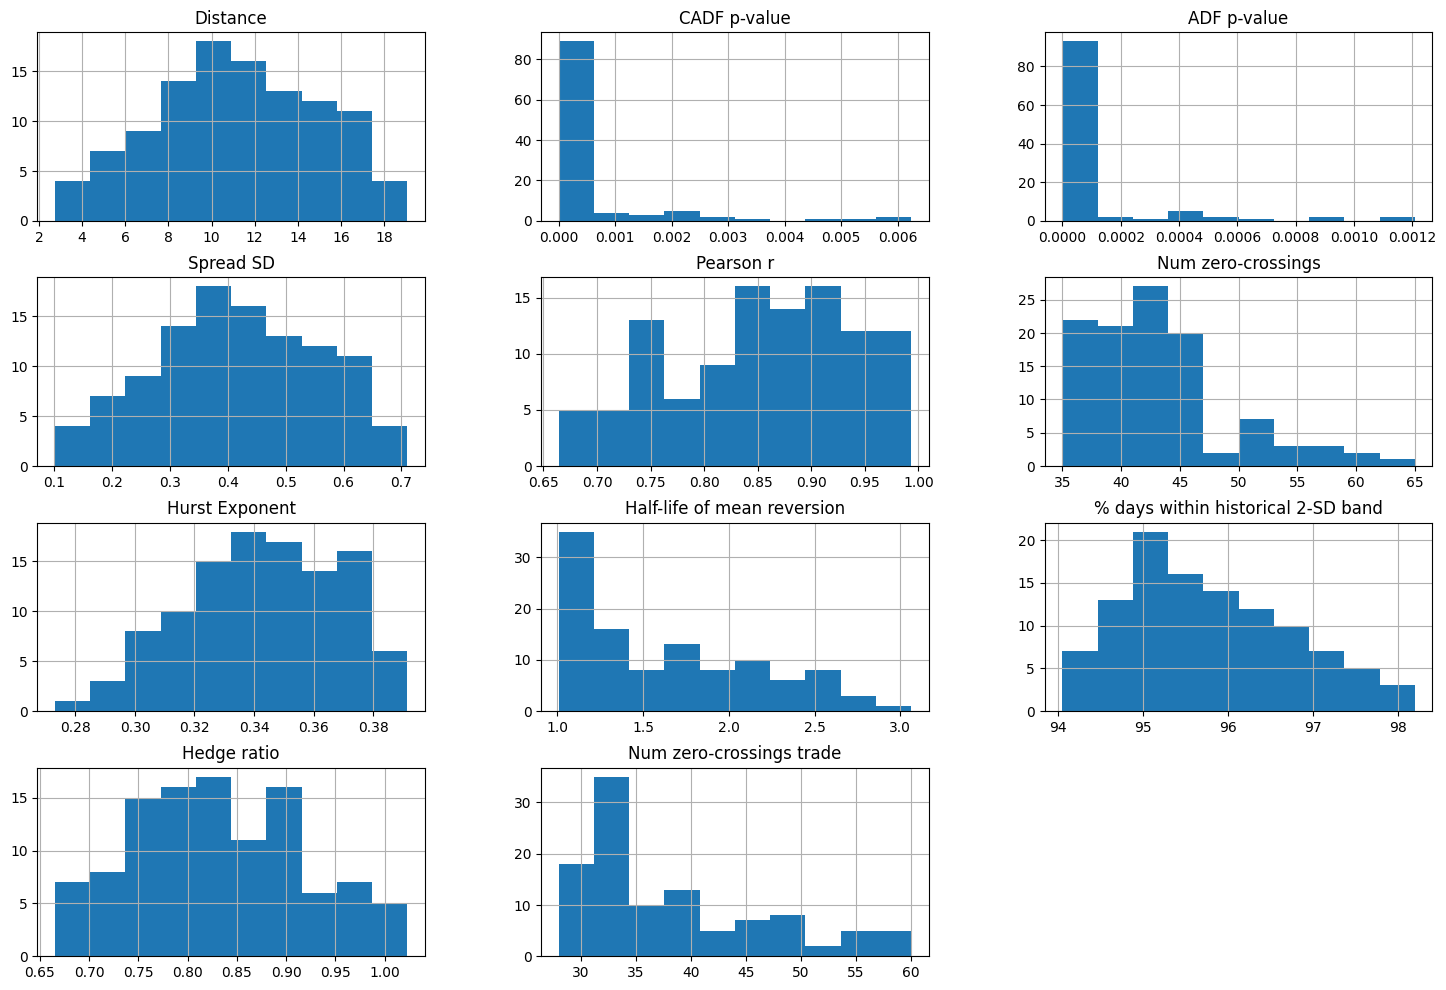

In [43]:
_ = data_train.hist(figsize=(18,12))

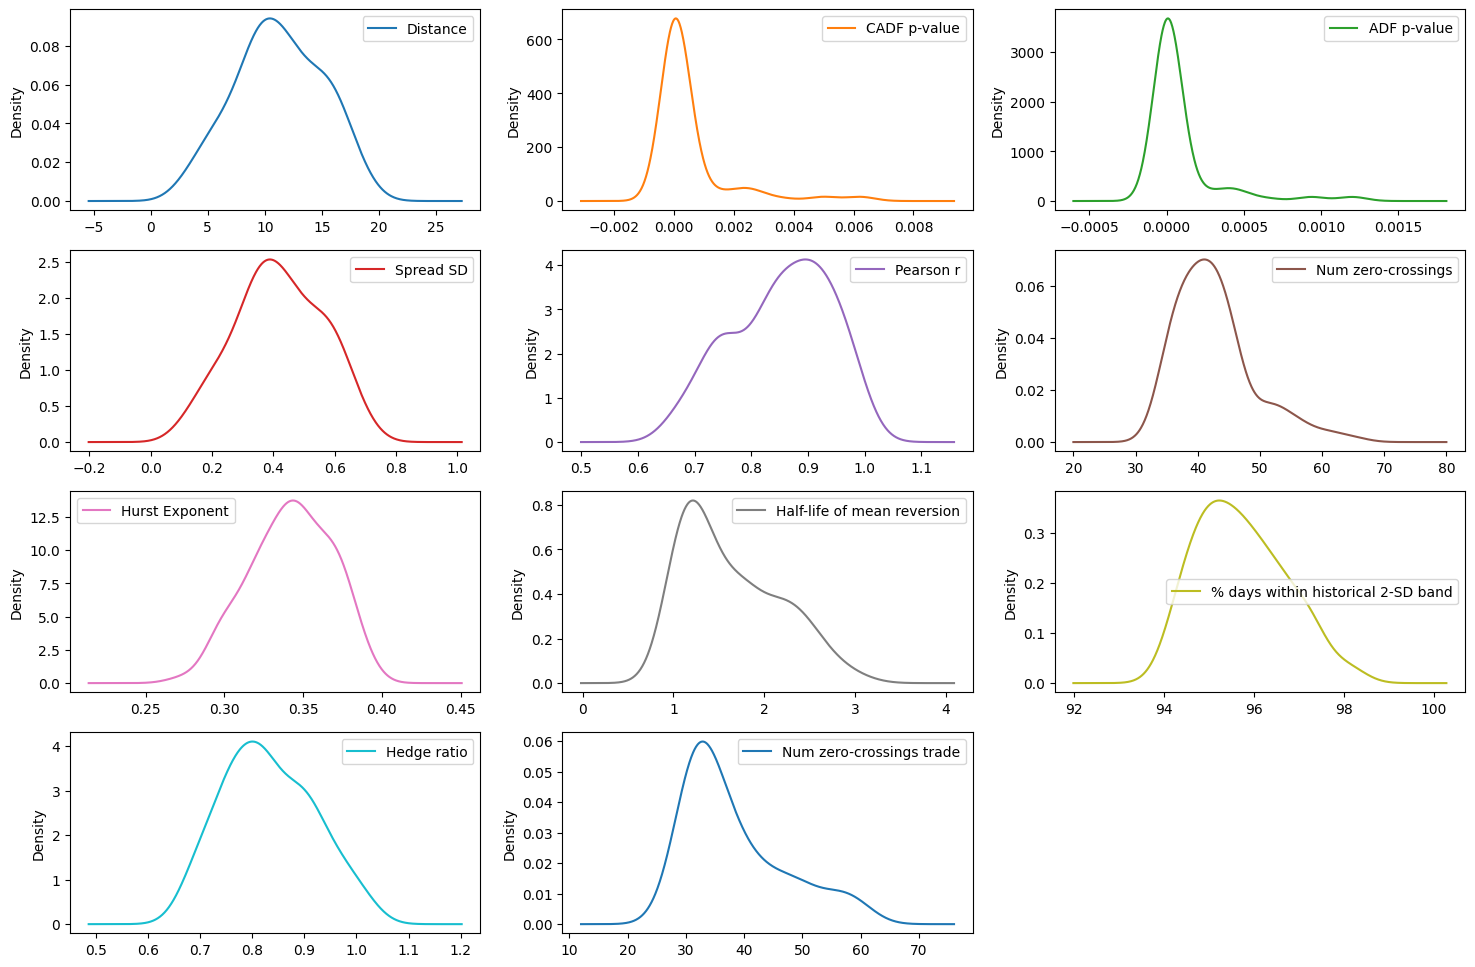

In [44]:
_ = data_train.plot(kind='density', subplots=True, layout=(4,3), sharex=False, figsize=(18,12))


In [45]:
X_train = data_train.values[:,:10]
X_test = data_test.values[:,:10]
y_train = data_train.values[:,10]
y_test = data_test.values[:,10]

In [46]:
# what fraction of samples has more than 6 crossings?
len(y_train[y_train>6]) / len(y_train)


1.0

In [47]:
from sklearn.preprocessing import Binarizer

# binarize dependent variable
binarizer = Binarizer(threshold=6).fit(y_train.reshape(-1,1))
y_train_bin = binarizer.transform(y_train.reshape(-1,1))
binarizer = Binarizer(threshold=6).fit(y_test.reshape(-1,1))
y_test_bin = binarizer.transform(y_test.reshape(-1,1))


In [48]:
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [49]:
def top10_accuracy(estimator, X, y):
    '''
    compute accuracy of top 10 predictions:
    select top 10 samples with the highest probability of belonging to class 1
    return the fraction of samples actually belonging to class1
    '''
    pred_prob = estimator.predict_proba(X)
    top10_ind = np.argsort(pred_prob[:,1])[-10:]
    score = sum(y[top10_ind] == np.ones(10))/10

    return score
def test_models_class(models, X=X_train, y=y_train_bin.flatten(), n_folds=10, scoring=top10_accuracy, seed=45):
    '''
    cross-validate each model in models using n_folds and scoring
    '''

    results = []
    names = []
    for name,model in models:
        kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        print(f'{name}: {cv_results.mean()} ({cv_results.std()})')

    return results, names

In [50]:
models = []
models.append(('LR', LogisticRegression(max_iter=300, class_weight='balanced')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(class_weight='balanced')))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(class_weight='balanced', probability=True)))

In [51]:
results,names = test_models_class(models, y=y_train_bin.flatten())


ValueError: ignored

In [53]:
pipelines = []
for name,model in models:
    pipelines.append((f'scaled{name}', Pipeline([('scaler', PowerTransformer(method='box-cox')),
                                                 (name,model)])))

results,names = test_models_class(pipelines, y=y_train_bin.flatten())

ValueError: ignored

In [54]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

pipelines = []
for name,model in models:
    pipelines.append((f'scaled{name}_4ft', Pipeline([('scaler', PowerTransformer(method='box-cox')),
                                                 ('KBest', SelectKBest(score_func=f_classif, k=4)),
                                                 (name,model)])))

results,names = test_models_class(pipelines, y=y_train_bin.flatten())

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value

ValueError: ignored

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

models = [('scaledLR_4ft_cv', Pipeline([('scaler', PowerTransformer(method='box-cox')),
                            ('KBest', SelectKBest(score_func=f_classif, k=4)),
                            ('LR', LogisticRegressionCV(max_iter=300, class_weight='balanced',
                                                        scoring=top10_accuracy))]))]

results,names = test_models_class(models, y=y_train_bin.flatten())

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value

ValueError: ignored

In [ ]:
print(grid_result.best_score_)
print(grid_result.best_params_)


NameError: ignored